In [ ]:
# import libraries
import torch
import numpy as np
import torch.nn as nn

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

# how many samples per batch to load
batch_size = 512

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

#transform=transforms.Compose([transforms.ToTensor(),
#                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                             ])

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

criterion = nn.CrossEntropyLoss()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear( 28*28 , 512 ) 
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear( 512, 10)
        # linear layer (n_hidden -> ?)
        # self.fc3 = nn.Linear(,)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28*28) 
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# initialize the NN
model_mlp = MLP().cuda()
print(model_mlp)
for parameter in model_mlp.parameters():
    print(parameter.shape)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
torch.Size([512, 784])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(in_channels=1,out_channels=16, kernel_size=5,stride=1,padding=2),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# initialize the NN
model_cnn = CNN().cuda()
print(model_cnn)
pcount = 0
for parameter in model_cnn.parameters():
    print(parameter.shape)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([10, 1568])
torch.Size([10])


In [ ]:
# training code
def train(model, optimizer, epochs=10):
    model.train() # prep model for training

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        
        ###################
        # train the model #
        ###################
        for data, target in train_loader:
            data = data.cuda()
            target = target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)[0]
            #print(output, data.shape)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
            
        # print training statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.dataset)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1, 
            train_loss
            ))

In [ ]:
# initialize lists to monitor test loss and accuracy
def test(model):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # prep model for *evaluation*

    for data, target in test_loader:
        data = data.cuda()
        target = target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)[0]
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(data.shape[0]):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [ ]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs
# specify optimizer
#model = Net()
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.05)
train(model_cnn, optimizer)

Epoch: 1 	Training Loss: 1.015469
Epoch: 2 	Training Loss: 0.273575
Epoch: 3 	Training Loss: 0.188179
Epoch: 4 	Training Loss: 0.149277
Epoch: 5 	Training Loss: 0.125839
Epoch: 6 	Training Loss: 0.110079
Epoch: 7 	Training Loss: 0.098782
Epoch: 8 	Training Loss: 0.090257
Epoch: 9 	Training Loss: 0.083508
Epoch: 10 	Training Loss: 0.078003


In [ ]:
test(model_cnn)

Test Loss: 0.083313

Test Accuracy of     0: 99% (975/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 96% (1001/1032)
Test Accuracy of     3: 98% (992/1010)
Test Accuracy of     4: 98% (970/982)
Test Accuracy of     5: 98% (875/892)
Test Accuracy of     6: 96% (926/958)
Test Accuracy of     7: 91% (945/1028)
Test Accuracy of     8: 96% (936/974)
Test Accuracy of     9: 97% (982/1009)

Test Accuracy (Overall): 97% (9732/10000)


In [ ]:
# how many samples per batch to load
batch_size = 512

# normlize data
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                             ])

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs
# specify optimizer
#model = Net()
# re-initialize the NN
model_cnn2 = CNN().cuda()
print(model_cnn2)

optimizer = torch.optim.SGD(model_cnn2.parameters(), lr=0.05)
train(model_cnn2, optimizer)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch: 1 	Training Loss: 0.821536
Epoch: 2 	Training Loss: 0.195987
Epoch: 3 	Training Loss: 0.137011
Epoch: 4 	Training Loss: 0.109940
Epoch: 5 	Training Loss: 0.093907
Epoch: 6 	Training Loss: 0.083086
Epoch: 7 	Training Loss: 0.075108
Epoch: 8 	Training Loss: 0.068878
Epoch: 9 	Training Loss: 0.063837
Epoch: 10 	Training Loss: 0.059647


In [ ]:
class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(in_channels=1,out_channels=16, kernel_size=5,stride=1,padding=2),                              
            nn.ReLU6(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU6(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.bn1 = nn.BatchNorm1d(32 * 7 * 7, affine=False)
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)     
        x = self.bn1(x)
        output = self.out(x)
        return output, x    # return x for visualization

# initialize the NN
model_cnn = CNN_BN()
print(model_cnn)
pcount = 0
for parameter in model_cnn.parameters():
    print(parameter.shape)

CNN_BN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU6()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU6()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([10, 1568])
torch.Size([10])


In [ ]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs
# specify optimizer
#model = Net()
# re-initialize the NN
model_cnn3 = CNN_BN().cuda()
print(model_cnn3)

optimizer = torch.optim.Adam(model_cnn3.parameters(), lr=0.015)
train(model_cnn3, optimizer)

CNN_BN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU6()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU6()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch: 1 	Training Loss: 0.202116
Epoch: 2 	Training Loss: 0.092467
Epoch: 3 	Training Loss: 0.069008
Epoch: 4 	Training Loss: 0.069581
Epoch: 5 	Training Loss: 0.071625
Epoch: 6 	Training Loss: 0.061363
Epoch: 7 	Training Loss: 0.053835
Epoch: 8 	Training Loss: 0.062253
Epoch: 9 	Training Loss: 0.057102
Epoch: 10 	Training Loss: 0.043952


In [ ]:
test(model_cnn3)

Test Loss: 0.345076

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 98% (1123/1135)
Test Accuracy of     2: 97% (1005/1032)
Test Accuracy of     3: 98% (994/1010)
Test Accuracy of     4: 98% (972/982)
Test Accuracy of     5: 97% (872/892)
Test Accuracy of     6: 97% (930/958)
Test Accuracy of     7: 98% (1011/1028)
Test Accuracy of     8: 99% (965/974)
Test Accuracy of     9: 95% (961/1009)

Test Accuracy (Overall): 98% (9803/10000)


(28, 28)

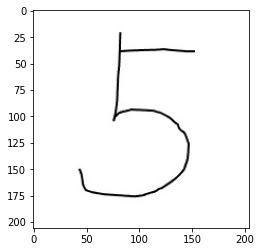

In [ ]:
import cv2
import numpy as np

img = cv2.imread('test_5_cunxi.jpg',cv2.IMREAD_GRAYSCALE)
res = cv2.resize(img, dsize=(28,28), interpolation=cv2.INTER_NEAREST)
plt.imshow(img,cmap='gray')
res.shape

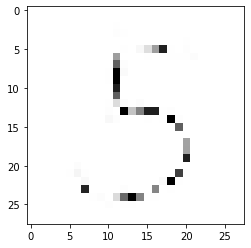

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(res,cmap='gray')

In [ ]:
pred = model_cnn3(torch.Tensor(res).view(1,1,28,28).cuda())
pred

(tensor([[-1332.5532,   406.3389,  -247.7416,  -198.2039,    42.5449,   634.0091,
           -322.6752,  1007.0002,   167.7179, -1632.5248]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[ 1.8666e+03,  3.0085e+01,  7.2311e+00,  ..., -1.7726e-42,
          -1.7726e-42, -1.7726e-42]], device='cuda:0',
        grad_fn=<NativeBatchNormBackward0>))

In [ ]:
torch.argmax(pred[0])

tensor(7, device='cuda:0')

(28, 28)

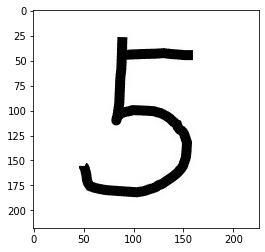

In [ ]:
img = cv2.imread('test_5_cunxi2.jpg',cv2.IMREAD_GRAYSCALE)
res = cv2.resize(img, dsize=(28,28), interpolation=cv2.INTER_NEAREST)
plt.imshow(img,cmap='gray')
res.shape

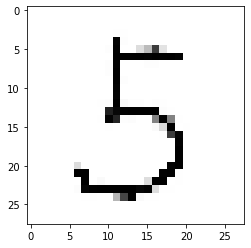

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(res,cmap='gray')

In [ ]:
torch.argmax(model_cnn3(torch.Tensor(res).view(1,1,28,28).cuda())[0])

tensor(2, device='cuda:0')